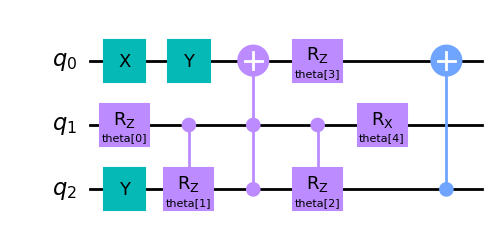

In [21]:
import random_circuit
individual = ECircuit(random_circuit.random_circuit(num_qubits, depth), fitness)
        
individual.qc.draw('mpl')

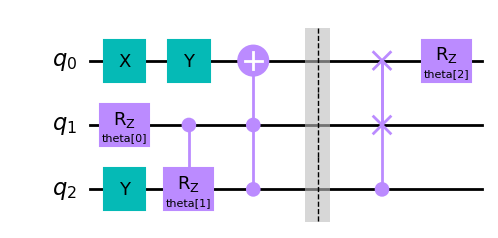

In [22]:
individual.mutate(qtm.evolution.mutate)
individual.qc.draw('mpl')

In [39]:
import numpy as np
import random
import types
import qiskit
import qtm.evolution
import random_circuit
import qtm.state
import qtm.qcompilation
%load_ext autoreload
%autoreload 2
class ECircuit():
    def __init__(self, qc: qiskit.QuantumCircuit, task: types.FunctionType) -> None:
        self.qc = qc
        self.task = task
        self.fitness = 0
        self.status = 'uncompile'
        return
    def compile(self):
        self.fitness = self.task(self.qc)
        self.status = 'compiled'
        return
    def mutate(self, mute_func: types.FunctionType):
        self.qc = mute_func(self.qc)
        return 
        
    def crossover(self, qc2, percent = 0.5):
        percent_sub1 = 1 - self.fitness / (self.fitness+ qc2.fitness)
        sub11, sub12 = qtm.evolution.divide_circuit(self.qc, percent_sub1)
        sub21, sub22 = qtm.evolution.divide_circuit(qc2.qc, 1 - percent_sub1)
        new_qc1 = ECircuit(qtm.evolution.compose_circuit([sub11, sub22]), self.task)
        new_qc2 = ECircuit(qtm.evolution.compose_circuit([sub21,sub12]), self.task)
        return new_qc1, new_qc2

def fitness(qc: qiskit.QuantumCircuit):
    compiler = qtm.qcompilation.QuantumCompilation(
        u = qc,
        vdagger = qtm.state.create_w_state(qc.num_qubits).inverse(),
        optimizer = 'adam',
        loss_func = 'loss_fubini_study'
    )
    compiler.fit(num_steps = 10, verbose = 0)
    return np.average(compiler.loss_values)
   
def create_population(num_individual, num_qubits, depth):
    population = []
    for _ in range(num_individual):
        individual = ECircuit(random_circuit.random_circuit(num_qubits, depth), fitness)
        individual.compile()
        population.append(individual)
    return population

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Iter:  0
0.726331779949543 
0.8379181951535584 
0.8269665474566761 
0.6435836200712994 
0.7506285033525775 
0.6444074739919508 
0.9136706611365624 
0.8470893607775599 
Iter:  1
0.8163600868861124 
0.8224945679554964 
0.8431343943211793 
0.837492047956869 
0.9001255920615197 
1.0 
0.8306638477568968 
0.8279056344917171 
Iter:  2
0.6430074745472617 
0.6472230413900647 
0.9143258879901619 
0.8471674635942634 
0.7496556011659006 
0.7280480154588248 
0.8269091852272069 
0.8378975210595048 
Iter:  3
0.8335166201993202 
0.8207350398807547 
0.84463145589289 
0.8405283862438411 
0.9024429725675436 
1.0 
0.8289705181336646 
0.8270434483789406 
Iter:  4
0.8492102358718894 
0.9189965166943868 
0.8350341707398984 
0.8322084884653618 
0.7495991899366041 
0.7307447310545591 
0.8258528409141302 
0.8388248804970866 
Iter:  5
0.8448599133400385 
0.8390550756800303 
0.5938250902883677 
0.7809317757060055 
0.8285131823564816 
0.8270627582032052 
0.8201537432613227 
0.8273669725431476 
Iter:  6
0.795880823

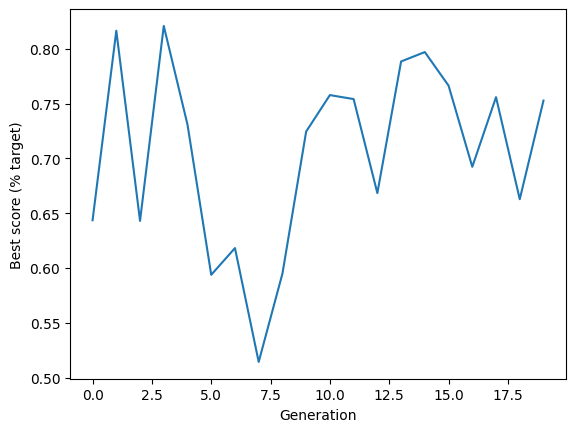

In [40]:
import matplotlib.pyplot as plt
depth = 5
num_individual = 16  # Must mod 8 = 0
maximum_generation = 20
best_score_progress = []  # Tracks progress
num_qubits = 3
threshold = 0.4
population = create_population(num_individual, num_qubits, depth)
for generation in range(maximum_generation):
    print("Iter: ", generation)
    population = sorted(population, key=lambda obj: obj.fitness)[
        :int(num_individual/2)]
    scores = []
    new_population = []
    for i in range(0, int(num_individual/2), 2):
        parent_1 = population[i]
        parent_2 = population[i+1]
        child_1, child_2 = parent_1.crossover(parent_2)
        child_1.compile()
        child_2.compile()
        new_population.append(child_1)
        scores.append(child_1.fitness)
        new_population.append(child_2)
        scores.append(child_2.fitness)
    for score in scores:
        print(f"{score} ")

    population = new_population
    prob_mutate = 0.01
    for individual in population:
        if random.random() < prob_mutate:
            individual.mutate(qtm.evolution.mutate) 
    # population = qtm.evolution.random_mutate(
    #     population, prob_mutate, qtm.evolution.mutate)

    best_score = np.min(scores)
    best_index = np.argmin(scores)
    best_score_progress.append(best_score)
    if best_score < threshold:
        break
print(population[best_index].qc)
# GA has completed required generation
print('End best score, percent target: %.1f' % best_score)

# Plot progress
%matplotlib inline
plt.plot(best_score_progress)
plt.xlabel('Generation')
plt.ylabel('Best score (% target)')
plt.show()


In [41]:
qc = population[best_index].qc
compiler = qtm.qcompilation.QuantumCompilation(
    u = qc,
    vdagger = qtm.state.create_w_state(qc.num_qubits).inverse(),
    # vdagger = qtm.state.create_haar_state(qc.num_qubits),
    optimizer = 'adam',
    loss_func = 'loss_fubini_study'
)
compiler.fit(num_steps = 100, verbose = 1)

Step: 100%|██████████| 100/100 [00:29<00:00,  3.43it/s]


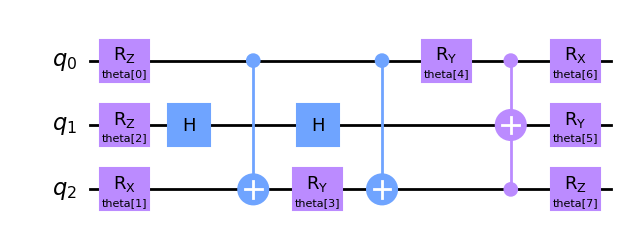

In [42]:
qc.draw('mpl')

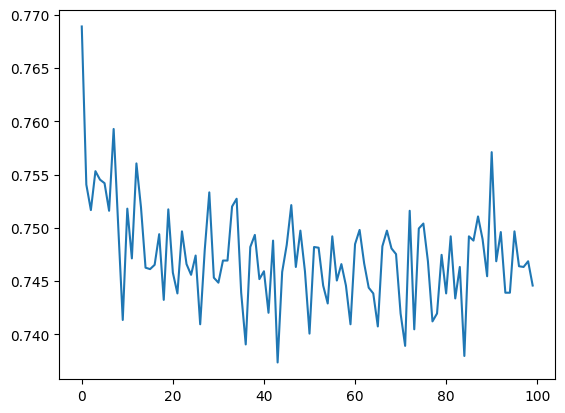

In [43]:
import matplotlib.pyplot as plt
plt.plot(compiler.loss_values)

ModuleNotFoundError: No module named 'tqdm'

Text(0.5, 1.0, 'Reward values')

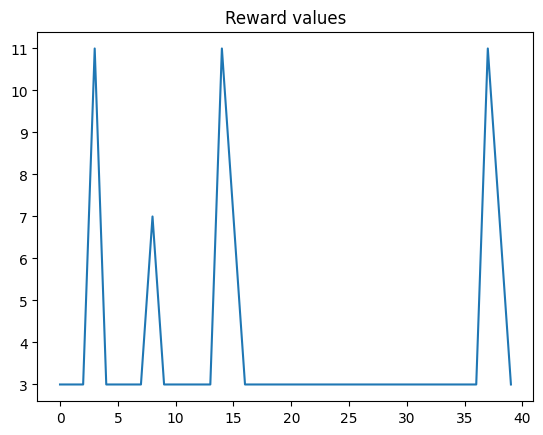

In [3]:
import pickle 
with open("/home/viet/EvolutionalQuantumCircuit/codes/train_rewards.pkl","rb") as handle:
    reward = pickle.load(handle)
import matplotlib.pyplot as plt
plt.plot(reward)
plt.title("Reward values")